# Running MAE on VIIRS data

In [1]:
# imports
from importlib import reload
import os
import numpy as np

import h5py

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from ulmo import io as ulmo_io
from ulmo.utils import image_utils
from ulmo.plotting import plotting
from ulmo.mae import reconstruct_LLC

/home/xavier/miniconda3/envs/os/lib/python3.10/site-packages/tqdm-4.65.0-py3.10.egg/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load VIIRS Table

In [3]:
sst_path = os.getenv('OS_SST')

In [4]:
viirs_file = os.path.join(sst_path, 'VIIRS', 'Tables', 'VIIRS_all_98clear_std.parquet')
viirs = ulmo_io.load_main_table(viirs_file)

Read main table: /home/xavier/Projects/Oceanography/SST/VIIRS/Tables/VIIRS_all_98clear_std.parquet


In [5]:
viirs.head()

,filename,row,col,lat,lon,clear_fraction,field_size,datetime,ex_filename,pp_file,...,pp_idx,pp_type,mean_temperature,Tmin,Tmax,T90,T10,LL,MODIS_LL,UID
0,s3://viirs/data/2012/032/20120201001000-OSPO-L...,3024,2784,19.337208,-176.89246,0.014025,192,2012-02-01 00:10:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,...,32205,0,26.662079,25.100006,27.660004,26.920013,26.429993,481.689453,486.260010,13281093372310754
1,s3://viirs/data/2012/032/20120201001000-OSPO-L...,3120,2688,20.116112,-176.30530,0.013943,192,2012-02-01 00:10:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,...,252131,0,26.312477,24.450012,27.149994,26.670013,25.809998,360.780640,379.500183,13281101161369470
2,s3://viirs/data/2012/032/20120201001000-OSPO-L...,3216,2496,21.009575,-175.17024,0.004693,192,2012-02-01 00:10:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,...,459126,0,26.149899,25.119995,26.790009,26.359985,25.950012,496.087891,482.765015,13281110096482976
3,s3://viirs/data/2012/032/20120201001000-OSPO-L...,3216,2592,20.876402,-175.80142,0.002740,192,2012-02-01 00:10:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,...,379958,0,26.039507,24.489990,26.889984,26.309998,25.829987,454.589905,493.697144,13281108764419858
4,s3://viirs/data/2012/032/20120201001000-OSPO-L...,3216,2688,20.725744,-176.50098,0.006565,192,2012-02-01 00:10:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,...,217941,0,25.925251,23.980011,27.029999,26.359985,25.609985,326.442383,328.781921,13281107257349902


# Find completely clear

In [6]:
all_clear = np.isclose(viirs.clear_fraction, 0.)
np.sum(all_clear)

923751

In [7]:
clear_viirs = viirs[all_clear].copy()

In [8]:
clear_viirs.head()

,filename,row,col,lat,lon,clear_fraction,field_size,datetime,ex_filename,pp_file,...,pp_idx,pp_type,mean_temperature,Tmin,Tmax,T90,T10,LL,MODIS_LL,UID
23,s3://viirs/data/2012/032/20120201013000-OSPO-L...,4272,192,-42.767250,-159.981770,1.463673e-16,192,2012-02-01 01:30:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,...,337702,0,16.150503,15.179993,17.429993,16.450012,15.670013,281.213318,305.681091,13284723282001823
24,s3://viirs/data/2012/032/20120201013000-OSPO-L...,4272,288,-43.076412,-161.011410,1.463673e-16,192,2012-02-01 01:30:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,...,492942,0,16.179958,15.399994,16.859985,16.420013,15.820007,502.220459,536.932861,13284692361898859
36,s3://viirs/data/2012/032/20120201023000-OSPO-L...,240,2496,37.592620,0.868959,-2.904803e-16,192,2012-02-01 02:30:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,...,710805,0,15.348452,14.250000,15.820007,15.570007,15.170013,456.507751,496.759888,1328127592618086896
37,s3://viirs/data/2012/032/20120201023000-OSPO-L...,240,2592,37.404587,1.596744,-2.904803e-16,192,2012-02-01 02:30:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,...,144083,0,15.289324,13.559998,16.130005,15.489990,15.109985,501.634094,532.935547,1328127404618159674
40,s3://viirs/data/2012/032/20120201023000-OSPO-L...,816,1728,35.628773,-8.543817,1.587376e-15,192,2012-02-01 02:30:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,...,71629,0,16.646990,15.769989,17.160004,16.910004,16.350006,382.582520,442.877380,1328125628817145618


# Let's check a few

## 2012

In [9]:
ex_file = os.path.join(sst_path, 'VIIRS', 'Extractions', 'VIIRS_2012_95clear_192x192_inpaint.h5')
pp_file = os.path.join(sst_path, 'VIIRS', 'PreProc', 'VIIRS_2012_95clear_192x192_preproc_viirs_std.h5')

In [10]:
f_pp2012 = h5py.File(pp_file, 'r')

In [11]:
f_ex2012 = h5py.File(ex_file, 'r')

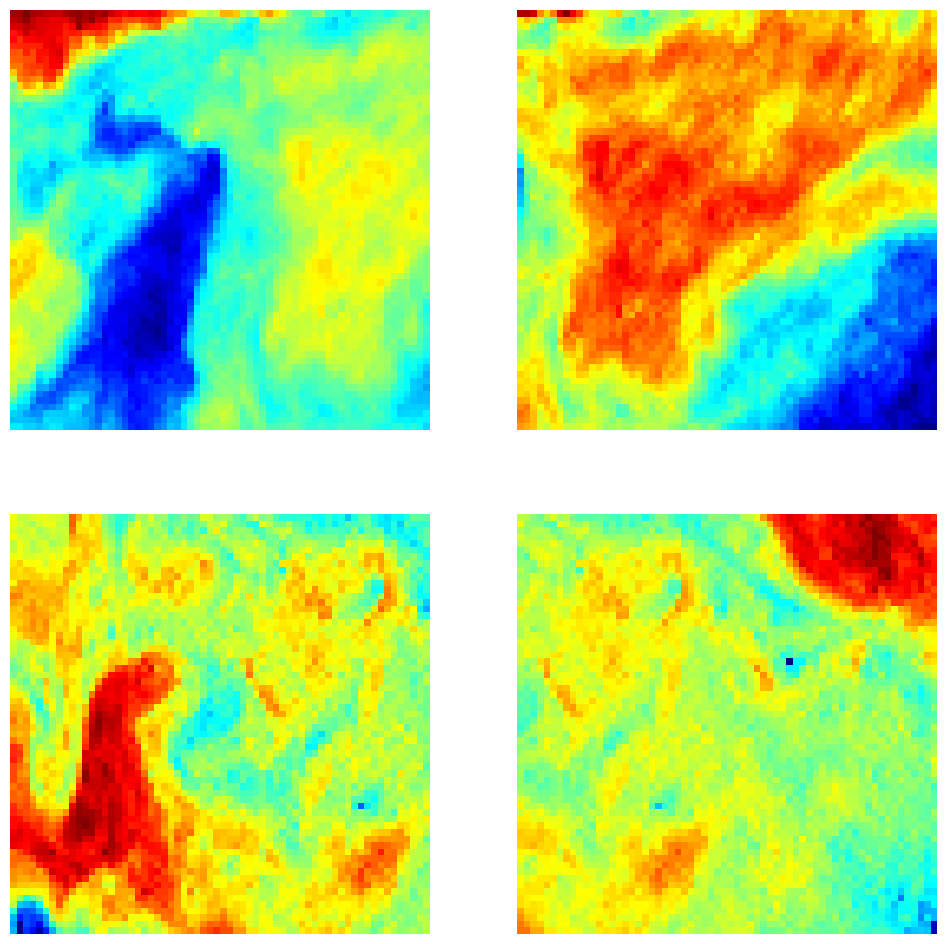

In [12]:
reload(plotting)
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(2,2)

for ss in range(4):
    # Axis
    ax = plt.subplot(gs[ss])
    # Img
    cutout = clear_viirs.iloc[ss]
    img, _ = image_utils.grab_image(cutout, pp_hf=f_pp2012, close=False)
    # Plot
    plotting.show_image(img, ax=ax, set_aspect='equal', cbar=False)

# 
plt.show()


----

# Reconstruct one!

## Load model

In [19]:
from ulmo.mae import models_mae
import torch

In [20]:
def prepare_model(chkpt_dir, arch='mae_vit_LLC_patch4'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

In [22]:
model = prepare_model('/home/xavier/Projects/Oceanography/OGCM/LLC/MAE/models/mae_t75_399.pth')

<All keys matched successfully>


## Do it

In [41]:
def run_one_image(img, model, mask_ratio):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *1)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)
    return mask, x, y

In [24]:
cutout = clear_viirs.iloc[0]
img, _ = image_utils.grab_image(cutout, pp_hf=f_pp2012, close=False)

In [27]:
rimg = np.resize(img, (64,64,1))

In [42]:
mask, x, y = run_one_image(rimg, model, 0.3)

### Detach

In [32]:
#recon_imag = x.cpu().detach().numpy()
m = mask.cpu().detach().numpy()

## Plot!

In [44]:
def show_image(image, title='', cm=None):
    # image is [H, W, 3]
    assert image.shape[2] == 1
    #plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int(), cmap=cm)
    #plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int(), cmap=cm)
    plt.imshow(image[:,:,0], cmap=cm)
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

tensor([[[-0.1627, -0.1527, -0.2016,  ..., -0.0694, -0.1094, -0.1872],
         [-0.2372, -0.2294, -0.2349,  ..., -0.1561, -0.1316, -0.1416],
         [-0.1983, -0.2205, -0.2805,  ..., -0.1905, -0.1949, -0.1449],
         ...,
         [ 0.8284,  0.8262,  0.8795,  ...,  0.1082,  0.1215,  0.1321],
         [ 0.8684,  0.8962,  0.9350,  ...,  0.0805,  0.0974,  0.1120],
         [ 0.9073,  0.9206,  0.9751,  ...,  0.0591,  0.0751,  0.0896]]])


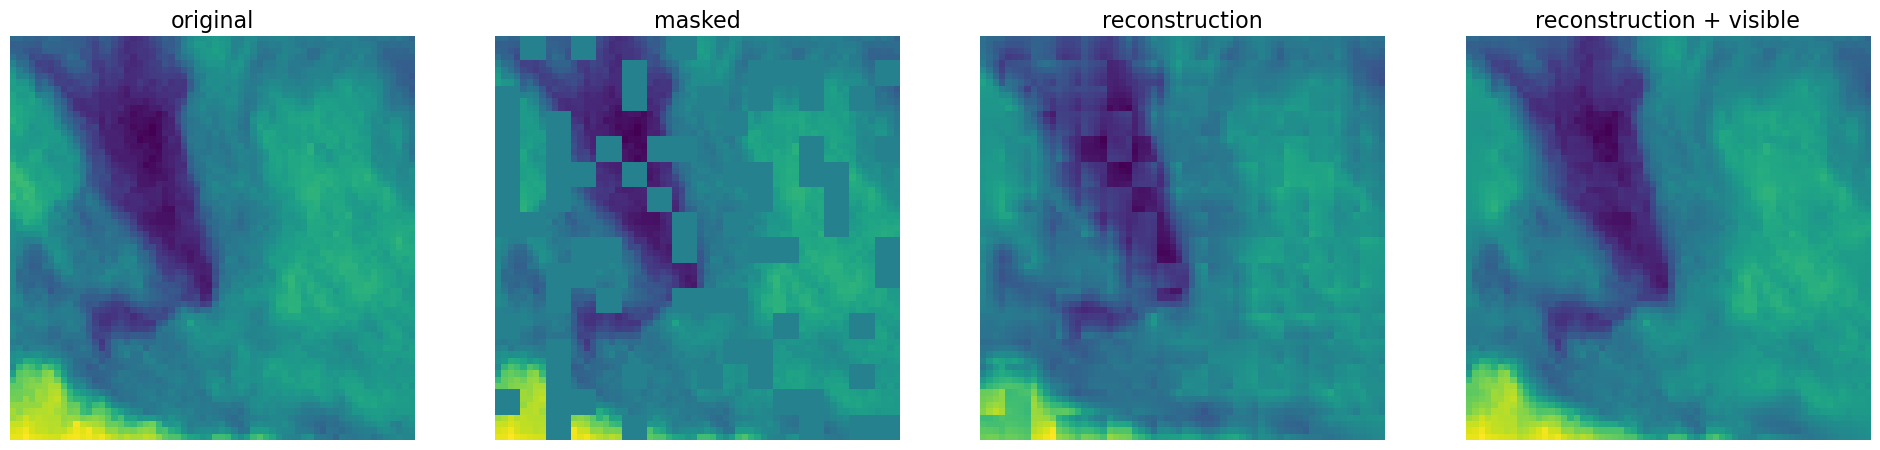

In [45]:
# masked image
im_masked = x * (1 - mask)

# MAE reconstruction pasted with visible patches
im_paste = x * (1 - mask) + y * mask

# make the plt figure larger
plt.rcParams['figure.figsize'] = [24, 24]

plt.subplot(1, 4, 1)
show_image(x[0], "original")

plt.subplot(1, 4, 2)
show_image(im_masked[0], "masked")

plt.subplot(1, 4, 3)
show_image(y[0], "reconstruction")

plt.subplot(1, 4, 4)
show_image(im_paste[0], "reconstruction + visible")
im = np.squeeze(im_paste, axis=3)
print(im)

plt.show()